In [ ]:
# ekonlpy 모듈 설치
!git clone https://github.com/entelecheia/eKoNLPy.git
!pip install ./eKoNLPy

In [ ]:
# konlpy 모듈 설치
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
# pdf 읽기용 tika 설치(채권 분석)
!pip install tika

In [ ]:
!pip3 install pdfminer.six
from pdfminer.pdfinterp import PDFResourceManager,PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO
from io import open

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

import re # 데이터 편집
import requests # 웹 상의 데이터를 가져올 때
from bs4 import BeautifulSoup #가져온 데이터에서 필요한 정보를 파싱할 때
from tqdm.notebook import tqdm

from datetime import datetime, timedelta

In [ ]:
from ekonlpy.sentiment import MPCK
mpck= MPCK()

# 데이터 수집 단계

## 의사록 수집_곽동명/ 유정현

In [ ]:
# 의사록 데이터 받아오기
pdf_list = []
hw_list= []
date_list = []
for i in range(5, 33):
  url = 'https://www.bok.or.kr/portal/bbs/B0000245/list.do?menuNo=200761&pageIndex={}'.format(i)

  resp = requests.get(url)
  soup = BeautifulSoup(resp.content, 'lxml')
  total = soup.select('div.fileGoupBox ul li a')
  b= soup.select('span.date')
  count=0

  for idx,a in enumerate(total):
    if (a['href'][1]=='p')&(a['title'][-3:]=='hwp'):
      hw_list.append([b[count].text,a['title'],a['href']])
      count+=1
    elif (a['href'][1]=='p')&(a['title'][-3:]=='pdf'):
      pdf_list.append([b[count-1].text,a['title'],a['href']])

In [ ]:
pdf_list2 = []
title_list2 = []
date_list2 = []

for i in range(len(pdf_list)):
  pdf_list2.append(pdf_list[i][2])
  title_list2.append(pdf_list[i][1])
  date_list2.append(pdf_list[i][0][3:])

In [ ]:
# 데이터 추출 및 저장
count=0
for i in range(len(pdf_list2)):
  url2 = 'http://www.bok.or.kr' + pdf_list2[i]
  if url2:
    count+=1
  file_res = requests.get(url2)
  with open('{}\n{}'.format(date_list2[i], title_list2[i]), 'wb') as f:
    f.write(file_res.content)

In [ ]:
#dataframe을 만들기 위해 회의 날짜를 크롤링
from tqdm.notebook import tqdm
import re

title_date = []
for i in tqdm(range(5, 33)):
  url = 'https://www.bok.or.kr/portal/bbs/B0000245/list.do?menuNo=200761&pageIndex={}'.format(i)

  resp = requests.get(url)
  soup = BeautifulSoup(resp.content, 'lxml')
  date = soup.select('span.titlesub')
  title_date.append(re.findall('\)\((.+?)\)', str(date)))

title_only = []
for i in range(len(title_date)):
  for j in range(len(title_date[0])):
    title_only.append(title_date[i][j])

for i in range(7):
  del(title_only[0])

del(title_only[-8:])

len(title_only)

265

In [ ]:
#pdf to txt 메소드
def convert_pdf_to_txt(title):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec = codec, laparams=laparams)
    fp = open('{}'.format(title), 'rb') # 여기에 저장된 url에 대한 response.content를 넣어줘야 함
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password = password, caching = caching, check_extractable=True):
        interpreter.process_page(page)
    text = retstr.getvalue()
    fp.close()
    device.close()
    retstr.close()
    return text

In [ ]:
titles = []
for i in range(len(date_list2)):
  titles.append('{}\n{}'.format(date_list2[i], title_list2[i]))

txt_contents = []
for i in range(len(titles)):
  txt_contents.append(convert_pdf_to_txt(titles[i]))

In [ ]:
# 5페이지 범위 밖 파일들 삭제(2018년 파일들)
for i in range(7):
  del(txt_contents[0])

In [ ]:
#hwp 파일 하나 업로드 후 텍스트만 뽑기
txt_contents.append(convert_pdf_to_txt('2005.06.28 2005년 제11차 금통위 의사록 - PDF파일.pdf'))

In [ ]:
#contents 문장 단위로 나눠주기
text_sentence = []
for i in tqdm(range(len(txt_contents))):
  text_sentence.append(txt_contents[i])

In [ ]:
def tidy_sentences(section):
    sentence_enders = re.compile(r'((?<=[함음됨임봄짐움])(\s*\n|\.|;)|(?<=다)\.)\s*')
    splits = list((m.start(), m.end()) for m in re.finditer(sentence_enders, section))
    starts = [0] + [i[1] for i in splits]
    ends = [i[0] for i in splits]
    sentences = [section[start:end] for start, end in zip(starts[:-1], ends)]
    for i, s in enumerate(sentences):
        sentences[i] = (s.replace('\n', ' ').replace(' ', ' ')) + '.'
    text = '\n'.join(sentences) if len(sentences) > 0 else ''
    return sentences, text

In [ ]:
def preprocess_minutes(minutes):
    pos = re.search('(.?국내외\s?경제\s?동향.?과 관련하여,?|\(가\).+경제전망.*|\(가\) 국내외 경제동향 및 평가)\n?\s*일부 위원은', minutes, re.MULTILINE)
    s1 = pos.start() if pos else -1
    pos = re.search('(.?외환.?국제금융\s?동향.?과 관련하여.*|\(나\) 외환.국제금융\s?(및 금융시장)?\s?동향)\n?\s*(일부 위원은|대부분의 위원들은)', minutes,re.MULTILINE)
    s2 = pos.start() if pos else -1
    pos = re.search('(.?금융시장\s?동향.?과 관련하여,?|\(다\) 금융시장\s?동향)\n?\s*일부 위원은', minutes, re.MULTILINE)
    s3 = pos.start() if pos else -1
    pos = re.search('((\((다|라)\) )?.?통화정책\s?방향.?에 관한 토론,?|이상과 같은 의견\s?교환을 바탕으로.*통화정책\s?방향.*에.*토론.*)\n?', minutes,re.MULTILINE)
    s4 = pos.start() if pos else -1
    pos = re.search('(\(4\) 정부측 열석자 발언.*)\n?', minutes, re.MULTILINE)
    s5 = pos.start() if pos else -1
    pos = re.search('(\(.*\) 한국은행 기준금리 결정에 관한 위원별 의견\s?개진|이상과 같은 토론에 이어 .* 관한 위원별 의견개진이 있었음.*)\n?', minutes,re.MULTILINE)
    s6 = pos.start() if pos else -1
    positer = re.finditer('(\(\s?.*\s?\) ()(심의결과|토의결론))\n?', minutes, re.MULTILINE)
    s7 = [pos.start() for pos in positer if pos.start() > s6]
    s7 = s7[0] if s7 else -1
    # 국내외 경제동향
    bos = s1
    eos = s2
    section = minutes[bos:eos] if bos >= 0 or eos >= 0 else ''
    pos = re.search('(일부|대부분의) 위원들?은', section, re.MULTILINE)
    bos = pos.start() if pos else -1
    section = section[bos:] if bos >= 0 else section
    section1, section1_txt = tidy_sentences(section)
    # 외환․국제금융 동향
    bos = s2
    eos = s3 if s3 >= 0 else s4
    section = minutes[bos:eos] if bos >= 0 or eos >= 0 else ''
    pos = re.search('(일부|대부분의) 위원들?은', section, re.MULTILINE)
    bos = pos.start() if pos else -1
    section = section[bos:] if bos >= 0 else section
    section2, section2_txt = tidy_sentences(section)
    #print(section)
    # 금융시장 동향
    bos = s3
    eos = s4
    section = minutes[bos:eos] if bos >= 0 or eos >= 0 else ''
    pos = re.search('(일부|대부분의) 위원들?은', section, re.MULTILINE)
    bos = pos.start() if pos else -1
    section = section[bos:] if bos >= 0 else section
    section3, section3_txt = tidy_sentences(section)
    # 통화정책방향
    bos = s4
    eos = s5 if s5 >= 0 else s6 if s6 >= 0 else s7
    section = minutes[bos:eos] if bos >= 0 or eos >= 0 else ''
    pos = re.search('(일부|대부분의) 위원들?은', section, re.MULTILINE)
    bos = pos.start() if pos else -1
    section = section[bos:] if bos >= 0 else section
    section4, section4_txt = tidy_sentences(section)
    # 위원별 의견 개진
    bos = s6
    eos = s7
    section = minutes[bos:eos] if bos >= 0 or eos >= 0 else ''
    pos = re.search('(일부|대부분의) 위원들?은', section, re.MULTILINE)
    bos = pos.start() if pos else -1
    section = section[bos:] if bos >= 0 else section
    section5, section5_txt = tidy_sentences(section)
    # 정부측 열석자 발언
    bos = s5
    eos = s6
    section = minutes[bos:eos] if bos >= 0 or eos >= 0 else ''
    pos = re.search('정부측 열석자 발언', section, re.MULTILINE)
    bos = pos.end() + 1 if pos else -1
    section = section[bos:] if bos >= 0 else section
    section6, section6_txt = tidy_sentences(section)
    
    sections = ['Economic Situation', 'Foreign Currency', 'Financial Markets',
                'Monetary Policy', "'Participants' Views", "'Government's View"]
    section_texts = (section2, section3)
    return  section_texts

In [ ]:
section_two_three = []
for i in tqdm(range(len(txt_contents))):
  section_two_three.append(preprocess_minutes(txt_contents[i]))

In [ ]:
section = []
for i in range(len(section_two_three)):
  section.append(section_two_three[i][0] + section_two_three[i][1])

In [ ]:
import pandas as pd
import numpy as np

dic_data = {'date': title_only, 'contents': section}
index = [i for i in range(len(txt_contents))]

df = pd.DataFrame(dic_data, index = index)
df

In [ ]:
df.to_csv("한국은행의사록.csv")

## 채권 분석 수집_염성현

In [ ]:
# 채권 분석 pdf 링크 수집.

no_page =126

report_link = []
report_yymm = []
for page in range(no_page):
  url = 'https://finance.naver.com/research/debenture_list.nhn'
  query={
    'page' : page+1
  }
  resp=requests.get(url,query)
  soup= BeautifulSoup(resp.content, 'lxml')
  a_tag=soup.select('tr td.file a')
  b_tag=soup.select('tr td.date')
  c_tag=[]
  for idx, b in enumerate(b_tag):
    if idx%2==0:
      c_tag.append(b)

  for a, c in zip(a_tag,c_tag):
    report_link.append(a['href'])
    report_yymm.append('20'+c.text)

len(report_link)

In [ ]:
#pdf 내용을 {}에 임시로 저장 후
#개행 문자, 태그를 제거한 뒤에 리스트에 저장.

full_pdf=[]
for link, yymm in tqdm(zip(report_link, report_yymm)):
  file_res = requests.get(link)
  with open('{}.pdf', 'wb') as f:
    f.write(file_res.content)
  # fp = open('{}.pdf', 'rb') # 여기에 저장된 url에 대한 response.content를 넣어줘야 함
  try:
    raw= parser.from_file('{}.pdf')
    v=raw['content']
    v=re.sub('[\n]', '', v)
    v=re.sub('<[^>]*>','',v)
    full_pdf.append([yymm,v])
  except:
    pass

In [ ]:
# 데이터프레임 형태로 저장.
# F=pd.DataFrame(full_pdf, columns=['date','contents'])

## 뉴스 수집_유정현/ 이규호

## 금리 수집_김민균



In [ ]:
#금리 데이터 받아오기

url = 'https://www.bok.or.kr/portal/singl/baseRate/list.do?dataSeCd=01&menuNo=200643'
resp = requests.get(url)
soup = BeautifulSoup(resp.content, 'lxml')
td_tag = soup.select('tbody tr td')
date = []
price = []
for i in range(len(td_tag)):
  if i % 3 ==0:
    datee = ''
    datee += td_tag[i].text
  elif i % 3 ==1:
    datee += td_tag[i].text
    date.append(''.join(re.findall('[0-9]+', datee)))
  else:
    price.append(td_tag[i].text)

selected = {}
selected['date'] = date
selected['interest_rate'] = price
features = pd.DataFrame(selected)

features

,date,interest_rate
0,20200528,0.50
1,20200317,0.75
2,20191016,1.25
3,20190718,1.50
4,20181130,1.75
5,20171130,1.50
6,20160609,1.25
7,20150611,1.50
8,20150312,1.75
9,20141015,2.00


In [ ]:
# 데이터 형태 맞춰주기(날짜)

start_date = datetime.strptime('20050101', '%Y%m%d')
end_date = datetime.strptime('20171231','%Y%m%d' )

str_date_list = [] 
while start_date.strftime('%Y%m%d') != end_date.strftime('%Y%m%d'):
    str_date_list.append(start_date.strftime('%Y%m%d')) 
    start_date += timedelta(days=1)
whole = pd.DataFrame(str_date_list, columns = ['date'])
whole

,date
0,20050101
1,20050102
2,20050103
3,20050104
4,20050105
...,...
4742,20171226
4743,20171227
4744,20171228
4745,20171229


In [ ]:
# 금리 데이터 채워주기.

merged = pd.merge(whole, features, how = 'left')
merged['interest_rate'][0] = 3.25
merged = merged.fillna(method = 'ffill')
merged

,date,interest_rate
0,20050101,3.25
1,20050102,3.25
2,20050103,3.25
3,20050104,3.25
4,20050105,3.25
...,...,...
4742,20171226,1.50
4743,20171227,1.50
4744,20171228,1.50
4745,20171229,1.50


In [ ]:
merged.to_csv('/content/drive/My Drive/NLP/data/interest.csv')

## 콜금리 수집_이규호

In [ ]:
# 콜 금리 받아오기.

from bs4 import BeautifulSoup
import requests

no_page = 693
dates =[]
call_rates = []
index = ['date', 'callrate']

for page in range(no_page):

  url = 'https://finance.naver.com/marketindex/interestDailyQuote.nhn'
  query = {
      'marketindexCd' : 'IRR_CALL',
      'page' : page+1
  }
  resp = requests.get(url, query)
  soup = BeautifulSoup(resp.content, 'lxml')

  date = soup.select('td.date')
  call_rate = soup.select('td.num')
  for i in range(len(date)):
    dates.append(date[i].text.strip())
    call_rates.append(call_rate[i*3-3].text.strip())
Call_rates = pd.DataFrame([dates, call_rates], index=index)
Call_rates = Call_rates.T
Call_rates.to_csv('Call_rates.csv')
#naver callrate crawl, transpose, save

In [ ]:
Call_rates

,date,callrate
0,2020.07.30,0.45
1,2020.07.29,0.49
2,2020.07.28,0.48
3,2020.07.27,0.47
4,2020.07.24,0.49
...,...,...
4846,2001.01.12,5.30
4847,2001.01.11,5.33
4848,2001.01.10,5.32
4849,2001.01.09,5.32


In [ ]:
# 콜금리 붙일 날짜 데이터 뼈대 만들어주기.

dt_index = pd.date_range(start='20041201', end='20171231')

dt_list = dt_index.strftime("%Y.%m.%d").tolist()
datels = []
for i in dt_list:
    datels.append(i)
#to make 'None' cells, use pandas
datels = datels[::-1]
dfno = pd.DataFrame([datels], index=['date'])
dfno = dfno.T
dfno

,date
0,2017.12.31
1,2017.12.30
2,2017.12.29
3,2017.12.28
4,2017.12.27
...,...
4774,2004.12.05
4775,2004.12.04
4776,2004.12.03
4777,2004.12.02


In [ ]:
# 날짜 데이터에 콜금리 데이터 붙여주기.
k = pd.merge(dfno, Call_rates, how='left')
k

,date,callrate
0,2017.12.31,NaN
1,2017.12.30,NaN
2,2017.12.29,1.52
3,2017.12.28,1.50
4,2017.12.27,1.55
...,...,...
4774,2004.12.05,NaN
4775,2004.12.04,NaN
4776,2004.12.03,3.26
4777,2004.12.02,3.26


In [ ]:
# 콜금리 NaN 데이터를 bfill을 활용해 이전 데이터로 채워주기.
# filling None cells with value of cell before them.. if the last cell's value was 'None', it wouecome moreld have b complicated job.
Call = k.fillna(method='bfill')
Call

,date,callrate
0,2017.12.31,1.52
1,2017.12.30,1.52
2,2017.12.29,1.52
3,2017.12.28,1.50
4,2017.12.27,1.55
...,...,...
4774,2004.12.05,3.26
4775,2004.12.04,3.26
4776,2004.12.03,3.26
4777,2004.12.02,3.26


In [ ]:
# 콜금리 30일차이 데이터 만들어주기.

Call_A = Call.loc[:][:][:-31]
Call_B = Call.loc[:][:][31:].rename({'date':'30일전 date', 'callrate':'30일전 callrate'}, axis='columns').reset_index(drop=True)

In [ ]:
CALLRATE = pd.merge(Call_A, Call_B, left_index=True, right_index=True)
# CALLRATE['한달전 date'][0], CALLRATE['한달전 callrate'][0] = CALLRATE['한달전 date'][1], CALLRATE['한달전 callrate'][1]# 12/31일이 그냥 슬라이싱 한거로 가져오면 12/01을 가져오게 되기 때문에 마지막 날만 맞춰줌... 근데 숫자만 31일 전으로 돌리는것 같아서 뭔가 잘못된것같네...다시해야겠다
CALLRATE['callrate']=CALLRATE['callrate'].astype(float)
CALLRATE['30일전 callrate']=CALLRATE['30일전 callrate'].astype(float)
CALLRATE#한달전을 30일전으로 따지기로 했음. 이유- 이미 많은 주말들을 fillna로 채워줬다. 

,date,callrate,30일전 date,30일전 callrate
0,2017.12.31,1.52,2017.11.30,1.48
1,2017.12.30,1.52,2017.11.29,1.53
2,2017.12.29,1.52,2017.11.28,1.25
3,2017.12.28,1.50,2017.11.27,1.26
4,2017.12.27,1.55,2017.11.26,1.26
...,...,...,...,...
4743,2005.01.05,3.21,2004.12.05,3.26
4744,2005.01.04,3.28,2004.12.04,3.26
4745,2005.01.03,3.29,2004.12.03,3.26
4746,2005.01.02,3.27,2004.12.02,3.26


In [ ]:
CALLRATE['Labeling']=np.where(CALLRATE['callrate']>CALLRATE['30일전 callrate'],'up',np.where(CALLRATE['callrate']==CALLRATE['30일전 callrate'],'-','down'))

In [ ]:
# up/ down 만 추출
datelabel=['date', 'Labeling']
Callrate_labeling = CALLRATE[datelabel]
Callrate_labeling

,date,Labeling
0,2017.12.31,up
1,2017.12.30,down
2,2017.12.29,up
3,2017.12.28,up
4,2017.12.27,up
...,...,...
4743,2005.01.05,down
4744,2005.01.04,up
4745,2005.01.03,up
4746,2005.01.02,up


In [ ]:
# 저장.
# Callrate_labeling.to_csv('Callrate_labeling.csv')

# 데이터 전처리

## 데이터 불러오기

In [ ]:
Naver=pd.read_csv('/content/drive/My Drive/NLP/data/naver.csv')
Bok=pd.read_csv('/content/drive/My Drive/NLP/data/BoK_minutes.csv')
Bond=pd.read_csv('/content/drive/My Drive/NLP/data/raw_F.csv')

In [ ]:
# 네이버 데이터 정제
Naver['date']=Naver['date'].apply( lambda x : re.sub('[가-힣]+|[A-z]+','',str(x)).replace(' ','')[:10])
Naver.columns=['j','g','date','contents']
Naver=Naver[['date','contents']]

In [ ]:
# 칼럼 이름 맞춰주기
Bok=Bok[['date','contents']]
Bond=Bond[['date','contents']]
Bond.dropna(inplace=True)

## 데이터 전처리/ 정제

In [ ]:
# [출처] [Python] 문자열 Cleansing(클렌징)|작성자 똑똑이

def clean_str(text):
    text=re.sub('[\n]', '', text)
    text=re.sub('<[^>]*>','',text)
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[^\w\s\.]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[0-9]+'         # 숫자제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[\이하Y\월\년\일\항\안\부\연]'
    text = re.sub(pattern=pattern, repl='', string=text)
    text=text.replace('........','.')
    text=text.replace('.......','.')
    text=text.replace('......','.')
    text=text.replace('.....','.')
    text=text.replace('....','.')
    text=text.replace('...','.')
    text=text.replace('..','.')
    text=text.replace('. . . . . .','.')
    text=text.replace('. . . . .','.')
    text=text.replace('. . . .','.')
    text=text.replace('. . .','.')
    text=text.replace('. .','.')
    text=text.replace('..','.')
    text=text.replace('. . .','.')
    text=text.replace('..','.')
    return text 

In [ ]:
Naver['contents']=Naver['contents'].apply(lambda x : clean_str(x))
Bond['contents']=Bond['contents'].apply(lambda x : clean_str(x))
Bok['contents']=Bok['contents'].apply(lambda x : clean_str(x))

In [ ]:
# 재사용을 위해 저장
# ALL_full.to_csv('/content/drive/My Drive/NLP/data/all_merged.csv')

## Tokenize



In [ ]:
# tokenize 메서드 작성
def n_tokenize(raw_data):
  raw_data['token']=raw_data['contents'].apply(lambda x : x.split('.'))
  for idx, contents in tqdm(enumerate(raw_data['token'])):
    token_only=[]
    for sentence in contents:
      tokens=mpck.tokenize(sentence)
      if tokens !=[]:
        token_only.append(tokens)
    raw_data['token'][idx]=token_only

In [ ]:
BB=pd.concat([Bond,Bok],axis=0)
ALL_full=pd.concat([Naver,BB])
ALL_full.reset_index(inplace=True)
ALL_full=ALL_full[['date','contents']]
ALL_full

,date,contents
0,2005.02.27,nt nt nn n ntntedaily 오상용기자 새한미디어 채권단은 회사의 경...
1,2005.02.27,nt nt nn n ntntedaily 정훈기자 급격한 고령화에 따른 장기 금융자산...
2,2005.02.27,nt nt nn n ntnt산합뉴스 김상현 기자 지난해 산지역 전체 금융기관의 총...
3,2005.02.27,nt nt nn n ntntedaily 홍정민기자 외환은행은 주가KOSPI와 환율U...
4,2005.02.27,nt nt nn n ntnt서울합뉴스 고준구 기자 외환은행은 주가지수와 원달러 ...
...,...,...
210675,2005.08.11,
210676,2005.07.07,
210677,2005.06.23,
210678,2005.06.09,


In [ ]:
# ALL_full.to_csv('/content/drive/My Drive/NLP/data/all_full.csv')

In [ ]:
# tokenize
n_tokenize(ALL_full)

In [ ]:
ALL_full

,date,contents,token
0,2005.02.27,nt nt nn n ntntedaily 오상용기자 새한미디어 채권단은 회사의 경...,"[[기자/NNG, 채권단/NNG, 경영/NNG, 정상화/NNG, 위하/VV, 대출/..."
1,2005.02.27,nt nt nn n ntntedaily 정훈기자 급격한 고령화에 따른 장기 금융자산...,"[[정훈/NNG, 기자/NNG, 급격/NNG, 고령화/NNG, 따르/VV, 장기/N..."
2,2005.02.27,nt nt nn n ntnt산합뉴스 김상현 기자 지난해 산지역 전체 금융기관의 총...,"[[산합/NNG, 뉴스/NNG, 기자/NNG, 산/NNG, 지역/NNG, 금융기관/..."
3,2005.02.27,nt nt nn n ntntedaily 홍정민기자 외환은행은 주가KOSPI와 환율U...,"[[기자/NNG, 주가/NNG, 코스피/NNG, 환율/NNG, 변동/NNG, 수익률..."
4,2005.02.27,nt nt nn n ntnt서울합뉴스 고준구 기자 외환은행은 주가지수와 원달러 ...,"[[합/NNG, 뉴스/NNG, 고준/NNG, 기자/NNG, 주가지수/NNG, 원달러..."
...,...,...,...
210675,2005.08.11,,[]
210676,2005.07.07,,[]
210677,2005.06.23,,[]
210678,2005.06.09,,[]


# 사전 구축

In [ ]:
# 콜금리와 금리 불러오기
call_lb=pd.read_csv('/content/drive/My Drive/NLP/실습 코드/BOK/Callrate_labeling.csv')

## 사전 구축 code 1:
문서 전체에서 바로 하기.

In [ ]:
from collections import defaultdict
corpus = defaultdict(lambda : [0,0,0]) # 왼쪽이 Hawkish, 오른쪽이 Dovish라고 일단 생각, 가운데 neutral

from tqdm.notebook import tqdm

for i in tqdm(range(len(labeled['contents']))): # 규호의 Label까지 merge 한 데이터의 제목, 규호왈 'contents'

    if labeled.iloc[i]['Labeling'] == 'up':
        tokens = mpck.tokenize(labeled.iloc[i]['contents']) 
        for ngrams in mpck.ngramize(tokens):
                corpus[ngrams][0] += 1
        for token in tokens:
            corpus[token][0] += 1
            
    elif labeled.iloc[i]['Labeling'] == 'down':
        tokens = mpck.tokenize(labeled.iloc[i]['contents'])
        for ngrams in mpck.ngramize(tokens):
                corpus[ngrams][2] += 1
        for token in tokens:
            corpus[token][2] += 1
    
    elif labeled.iloc[i]['Labeling'] == '-':
        tokens = mpck.tokenize(labeled.iloc[i]['contents'])
        for ngrams in mpck.ngramize(tokens):
                corpus[ngrams][1] += 1
        for token in tokens:
            corpus[token][1] += 1

## 사전 구축 code 2:
문서 내에서 문장 접근.

In [ ]:
def corpus_maker(raw_data):
  # total count/ up count/ down count
  corpus = defaultdict(lambda : [0,0,0])
  for idx,token_book in tqdm(enumerate(raw_data['token'])):
    for token_list in token_book:
      ngrams=mpck.ngramize(token_list)
    # n-gram 사전 구축.
      for ngram in ngrams:
        if raw_data.iloc[idx].Labeling=='up':
          corpus[ngram][0]+=1
          corpus[ngram][1]+=1
        elif raw_data.iloc[idx].Labeling=='down':
          corpus[ngram][0]+=1
          corpus[ngram][2]+=1
        else:
          corpus[ngram][0]+=1
    # uni-gram 사전 추가.
      for tokens in token_list:
        if tokens[-3:] != 'XSV':
          if raw_data.iloc[idx].Labeling=='up':
            corpus[tokens][0]+=1
            corpus[tokens][1]+=1
          elif raw_data.iloc[idx].Labeling=='down':
            corpus[tokens][0]+=1
            corpus[tokens][2]+=1
          else:
            corpus[tokens][0]+=1
  return corpus

In [ ]:
all_lb=ALL_full.merge(call_lb,on='date')
all_corp=corpus_maker(all_lb)

In [ ]:
corp_dic=pd.DataFrame(all_corp).T
corp_dic.columns=['total','up','down']

In [ ]:
corp_dic

,total,up,down
합/NNG,121823,41982,52218
뉴스/NNG,70255,26583,30024
기자/NNG,148235,55783,61601
원/NNG,98108,36388,40241
달러/NNG,309372,112813,129317
...,...,...,...
거슬러가/VV,1,1,0
나눠가졌/VV,1,1,0
恒數/NNG,1,1,0
쉬운데도/VA,1,1,0


In [ ]:
corp_dic.to_csv('/content/drive/My Drive/NLP/data/corp_dic.csv')

In [ ]:
corp_dic['polar_score']=((corp_dic['up']/corp_dic['total'])/(corp_dic['up'].sum()/corp_dic['total'].sum()))/((corp_dic['down']/corp_dic['total'])/(corp_dic['down'].sum()/corp_dic['total'].sum()))

In [ ]:
for idx, value in enumerate(corp_dic['polar_score']):
  # feature selection 단계에서 total>15 판별하지 않고 여기서 한 번에 작업
  if corp_dic.iloc[idx].total >14:
    if value > (13/10):
      corp_dic['polarity'][idx]='Hawkish'
    elif value < (10/13):
      corp_dic['polarity'][idx]='Dovish'
    else:
      corp_dic['polarity'][idx]='Nothing'
  else:
    corp_dic['polarity'][idx]='Nothing'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/py

In [ ]:
corp_dic

,total,up,down,polar_score,polarity
합/NNG,121823,41982,52218,0.886638,Nothing
뉴스/NNG,70255,26583,30024,0.976425,Nothing
기자/NNG,148235,55783,61601,0.998660,Nothing
원/NNG,98108,36388,40241,0.997225,Nothing
달러/NNG,309372,112813,129317,0.962071,Nothing
...,...,...,...,...,...
거슬러가/VV,1,1,0,inf,Nothing
나눠가졌/VV,1,1,0,inf,Nothing
恒數/NNG,1,1,0,inf,Nothing
쉬운데도/VA,1,1,0,inf,Nothing


In [ ]:
hawkish_dic=corp_dic[corp_dic['polarity']=='Hawkish']
dovish_dic=corp_dic[corp_dic['polarity']=='Dovish']

In [ ]:
hawkish_dic

,total,up,down,polar_score,polarity
공익/NNG,476,215,171,1.386583,Hawkish
신용카드결제/NNG,146,70,57,1.354337,Hawkish
경영실태평가/NNG,95,42,35,1.323381,Hawkish
주택담보대출/NNG;금리/NNG;오르/VV,126,60,43,1.538815,Hawkish
서브프라임/NNG,5103,2798,1926,1.602120,Hawkish
...,...,...,...,...,...
유료뉴스/NNG;시장/NNG;플러스/NNG,364,199,119,1.844207,Hawkish
fed/NNG;금리/NNG;인상/NNG;종결/NNG,16,10,4,2.757043,Hawkish
가시각/NNG,26,15,10,1.654226,Hawkish
환시채/NNG,20,9,5,1.985071,Hawkish


In [ ]:
dovish_dic

,total,up,down,polar_score,polarity
법상/NNG,587,173,320,0.596211,Dovish
회피/NNG,5765,1819,2667,0.752165,Dovish
유례없/VA,584,162,326,0.548026,Dovish
인/NNG,63215,19746,30660,0.710249,Dovish
돈/NNG;넘/VV,79,24,37,0.715341,Dovish
...,...,...,...,...,...
洙/NNG,17,6,9,0.735211,Dovish
중대형/NNG;공급/NNG;확대/NNG,23,5,14,0.393863,Dovish
양적/VAX;통화/NNG;완화정책/NNG;종료/NNG,29,10,19,0.580430,Dovish
분기역/NNG,15,1,13,0.084832,Dovish


뉴스, 기자와 같이 상관없는 글자가 사전에 담기지 않았나 확인  
기준은 1000개 이상 showup한 데이터

In [ ]:
Hawkish[Hawkish['total']>1000].sort_values('total',ascending=False)

,Unnamed: 0,total,up,down,polar_score,polarity
17,긴축/NNG,18568,8918,6033,1.630188,Hawkish
221,인플레이션/NNG,16021,7652,5466,1.543863,Hawkish
14,콜/NNG,11689,6278,3852,1.797374,Hawkish
99,선임/NNG,10773,5126,3594,1.572911,Hawkish
304,금지/NNG,9624,4593,3379,1.499035,Hawkish
...,...,...,...,...,...,...
1039,시동/NNG,1024,463,375,1.361612,Hawkish
1134,한경/NNG,1020,493,358,1.518684,Hawkish
900,한국인/NNG,1006,467,353,1.458968,Hawkish
111,장내시장/NNG,1002,495,388,1.406945,Hawkish


In [ ]:
Dovish[Dovish['total']>1000].sort_values('total',ascending=False)

,Unnamed: 0,total,up,down,polar_score,polarity
3,인/NNG,63215,19746,30660,0.710249,Dovish
290,양적완화/NNG,33651,10375,15048,0.760349,Dovish
167,금융위기/NNG,22646,7328,11164,0.723884,Dovish
191,양책/NNG,14243,4183,6780,0.680396,Dovish
113,협상/NNG,11435,3427,5340,0.707744,Dovish
...,...,...,...,...,...,...
841,뮤/NNG,1039,318,470,0.746161,Dovish
868,모직/NNG,1017,232,380,0.673299,Dovish
138,安/NNG,1014,301,444,0.747631,Dovish
143,금융경제/NNG,1014,333,505,0.727204,Dovish


직접 확인해보니 뉴스, 기자와 같이 문서 내용과 무관한 토큰은 제거되어 있음을 알 수 있었음.

In [ ]:
# 재사용을 위한 데이터 저장
corp_dic.to_csv('/content/drive/My Drive/NLP/data/corpus_dic.csv')
hawkish_dic.to_csv('/content/drive/My Drive/NLP/data/hawkish_dic.csv')
dovish_dic.to_csv('/content/drive/My Drive/NLP/data/dovish_dic.csv')

# 금통위 의사록 어조 분석

In [ ]:
# 의사록, 금리 및 Hawkish, Dovish 불러오기
Bok_minutes=pd.read_csv('/content/drive/My Drive/NLP/data/BoK_minutes.csv')
interest=pd.read_csv('/content/drive/My Drive/NLP/data/interest.csv')
Dovish = pd.read_csv('/content/drive/My Drive/NLP/data/dovish_dic.csv')
Hawkish = pd.read_csv('/content/drive/My Drive/NLP/data/hawkish_dic.csv')
Bok_minutes=Bok_minutes[['date','contents']]
interest['date']=interest['date'].apply(lambda x: str(x)[:4]+'.'+str(x)[4:6]+'.'+str(x)[6:])

In [ ]:
Hawkish.columns=['hawkish','total','up','down','polar_score','polarity']
Dovish.columns=['dovish','total','up','down','polar_score','polarity']
Hawkish=Hawkish[['hawkish']]
Dovish=Dovish[['dovish']]

In [ ]:
Hawkish

,hawkish
0,공익/NNG
1,신용카드결제/NNG
2,경영실태평가/NNG
3,주택담보대출/NNG;금리/NNG;오르/VV
4,서브프라임/NNG
...,...
10860,유료뉴스/NNG;시장/NNG;플러스/NNG
10861,fed/NNG;금리/NNG;인상/NNG;종결/NNG
10862,가시각/NNG
10863,환시채/NNG


In [ ]:
Dovish

,dovish
0,법상/NNG
1,회피/NNG
2,유례없/VA
3,인/NNG
4,돈/NNG;넘/VV
...,...
10155,洙/NNG
10156,중대형/NNG;공급/NNG;확대/NNG
10157,양적/VAX;통화/NNG;완화정책/NNG;종료/NNG
10158,분기역/NNG


In [ ]:
dovish_list = list(Dovish['dovish'])
hawkish_list = list(Hawkish['hawkish'])

In [ ]:
# 토크나이즈 재현
Bok_minutes['contents']=Bok_minutes['contents'].apply(lambda x : clean_str(x))
n_tokenize(Bok_minutes)
Bok_minutes

,date,contents,token
0,2017.12.28,,[]
1,2017.12.14,,[]
2,2017.12.07,,[]
3,2017.11.30,위원은 최근 미국의 금융경제상황을 보면 금 미 준 금리를 인상할 것으로 예견되...,"[[금융경제/NNG, 보/VV, 금/NNG, 미/NNG, 금리/NNG, 인상/NNG..."
4,2017.11.09,,[]
...,...,...,...
260,2005.08.11,,[]
261,2005.07.07,,[]
262,2005.06.23,,[]
263,2005.06.09,,[]


In [ ]:
# 빈 문서 제거
Bok_minutes=Bok_minutes[Bok_minutes['contents']!='']
Bok_minutes.reset_index(inplace=True)

In [ ]:
Bok_minutes

,index,date,contents,token,tone
0,3,2017.11.30,위원은 최근 미국의 금융경제상황을 보면 금 미 준 금리를 인상할 것으로 예견되...,"[[금융경제/NNG, 보/VV, 금/NNG, 미/NNG, 금리/NNG, 인상/NNG...",0.333333
1,5,2017.10.19,위원은 최근 미국에서는 임금상승세가 확대되고 세제개혁에 대한 기대 감 커지면서 ...,"[[임금/NNG, 상승/NNG, 확대/NNG, 되/XSV, 세제/NNG, 개혁/NN...",0.363636
2,7,2017.08.31,위원은 미국의 금리 정상화 행보에도 불구고 미 달러화가 약세기조를 지속면서 신흥...,"[[금리정상화/NNG, 행보/NNG, 불구/NNG, 미/NNG, 달러/NNG, 약세...",-0.047619
3,9,2017.07.13,위원은 주요국에서는 성장과 고용 회복국면의 정점을 향해 가고 있음. 에도 불구고 ...,"[[성장/NNG, 고용/NNG, 회복국면/NNG, 정점/NNG, 향하/VV], [불...",0.230769
4,11,2017.05.25,위원은 최근 국제금융시장 정된 모습을 지속는 가운데 국내금융 시장도 외국인 증권...,"[[국제/NNG, 금융시장/NNG, 정/NNG, 되/VV, 지속/NNG, 가운데/N...",-0.411765
...,...,...,...,...,...
112,204,2008.04.10,위원은 최근 미준의 금리인 및 유동성 공급 확대조치에도 불구고 미국의 주택가...,"[[미준/NNG, 금리/NNG, 유동성/NNG, 공급/NNG, 확대/NNG, 조치/...",-0.037037
113,206,2008.03.07,위원은 물량 개마다 집중적으로 롤오버 rollover 는 것으로 알려지고 ...,"[[물량/NNG, 개/NNG, 집중/NNG, 롤오버/NNG, 알려/VV, 를/NNG...",0.24
114,207,2008.02.13,위원은 최근 미국 채권보증기관의 신용등급 락 등으로 국제금융시장의 신용경색 심...,"[[채권보증/NNG, 기관/NNG, 신용등급/NNG, 락/NNG, 국제/NNG, 금...",0.134328
115,222,2007.06.08,위원은 우리나라의 정채 및 대외채의 증가 국제유가 상승 교역조건 악화 등으로 우...,"[[정채/NNG, 외채/NNG, 증가/NNG, 국제/NNG, 유가/NNG, 상승/N...",0.253731


In [ ]:
# 톤 갯수 구하기
docu_score_list = []
for i in range(len(Bok_minutes)):
  BoK_score_list = []
  for sentence in Bok_minutes['token'][i]:
    dict_sentence = [[], []]
    for token in sentence:
      if token in dovish_list: 
        dict_sentence[1].append(token)     
      elif token in hawkish_list:
        dict_sentence[0].append(token)
    tone_score = []
    if (len(dict_sentence[0]) + len(dict_sentence[1])) == 0:
      tone_score.append('')
    else:
      tone_score.append((len(dict_sentence[0])- len(dict_sentence[1])) / (len(dict_sentence[0]) + len(dict_sentence[1])))
    BoK_score_list.append(tone_score)
  docu_score_list.append(BoK_score_list)

In [ ]:
# 톤 스코어 구하기
each_docu_tone = []
for i in range(len(docu_score_list)):
  docu_tone = []
  if docu_score_list[i] == []:
    docu_tone.append('')
  else:
    no_of_hawkish = 0
    no_of_dovish = 0
    for j in range(len(docu_score_list[i])):
      if docu_score_list[i][j][0] != '':
        if docu_score_list[i][j][0] > 0:
          no_of_hawkish += 1
        elif docu_score_list[i][j][0] < 0:
          no_of_dovish += 1
      else:
        continue
    tone = (no_of_hawkish - no_of_dovish) / (no_of_hawkish + no_of_dovish)
    docu_tone.append(tone)
  
  each_docu_tone.append(docu_tone)

In [ ]:
# 본 칼럼과 합쳐주기
Bok_minutes['tone'] =  Bok_minutes['date']
Bok_minutes
for i in range(len(each_docu_tone)):
  Bok_minutes['tone'][i] = each_docu_tone[i][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
Bok_minutes

,index,date,contents,token,tone
0,3,2017.11.30,위원은 최근 미국의 금융경제상황을 보면 금 미 준 금리를 인상할 것으로 예견되...,"[[금융경제/NNG, 보/VV, 금/NNG, 미/NNG, 금리/NNG, 인상/NNG...",0.333333
1,5,2017.10.19,위원은 최근 미국에서는 임금상승세가 확대되고 세제개혁에 대한 기대 감 커지면서 ...,"[[임금/NNG, 상승/NNG, 확대/NNG, 되/XSV, 세제/NNG, 개혁/NN...",0.363636
2,7,2017.08.31,위원은 미국의 금리 정상화 행보에도 불구고 미 달러화가 약세기조를 지속면서 신흥...,"[[금리정상화/NNG, 행보/NNG, 불구/NNG, 미/NNG, 달러/NNG, 약세...",-0.047619
3,9,2017.07.13,위원은 주요국에서는 성장과 고용 회복국면의 정점을 향해 가고 있음. 에도 불구고 ...,"[[성장/NNG, 고용/NNG, 회복국면/NNG, 정점/NNG, 향하/VV], [불...",0.230769
4,11,2017.05.25,위원은 최근 국제금융시장 정된 모습을 지속는 가운데 국내금융 시장도 외국인 증권...,"[[국제/NNG, 금융시장/NNG, 정/NNG, 되/VV, 지속/NNG, 가운데/N...",-0.411765
...,...,...,...,...,...
112,204,2008.04.10,위원은 최근 미준의 금리인 및 유동성 공급 확대조치에도 불구고 미국의 주택가...,"[[미준/NNG, 금리/NNG, 유동성/NNG, 공급/NNG, 확대/NNG, 조치/...",-0.037037
113,206,2008.03.07,위원은 물량 개마다 집중적으로 롤오버 rollover 는 것으로 알려지고 ...,"[[물량/NNG, 개/NNG, 집중/NNG, 롤오버/NNG, 알려/VV, 를/NNG...",0.24
114,207,2008.02.13,위원은 최근 미국 채권보증기관의 신용등급 락 등으로 국제금융시장의 신용경색 심...,"[[채권보증/NNG, 기관/NNG, 신용등급/NNG, 락/NNG, 국제/NNG, 금...",0.134328
115,222,2007.06.08,위원은 우리나라의 정채 및 대외채의 증가 국제유가 상승 교역조건 악화 등으로 우...,"[[정채/NNG, 외채/NNG, 증가/NNG, 국제/NNG, 유가/NNG, 상승/N...",0.253731


In [ ]:
Bok_interest= interest.merge(Bok_minutes, how='inner', on='date')
Bok_interest

,Unnamed: 0,date,interest_rate,index,contents,token,tone
0,131,2005.05.12,3.25,264,위원은 내외금리차 역전에 따라 자금의 해외유출 대규모로 발생될 가능성을 상당히 ...,"[[내외/NNG, 금리갭/NNG, 역전/NNG, 자금/NNG, 해외/NNG, 유출/...",0.454545
1,888,2007.06.08,4.50,222,위원은 우리나라의 정채 및 대외채의 증가 국제유가 상승 교역조건 악화 등으로 우...,"[[정채/NNG, 외채/NNG, 증가/NNG, 국제/NNG, 유가/NNG, 상승/N...",0.253731
2,1138,2008.02.13,5.00,207,위원은 최근 미국 채권보증기관의 신용등급 락 등으로 국제금융시장의 신용경색 심...,"[[채권보증/NNG, 기관/NNG, 신용등급/NNG, 락/NNG, 국제/NNG, 금...",0.134328
3,1161,2008.03.07,5.00,206,위원은 물량 개마다 집중적으로 롤오버 rollover 는 것으로 알려지고 ...,"[[물량/NNG, 개/NNG, 집중/NNG, 롤오버/NNG, 알려/VV, 를/NNG...",0.24
4,1195,2008.04.10,5.00,204,위원은 최근 미준의 금리인 및 유동성 공급 확대조치에도 불구고 미국의 주택가...,"[[미준/NNG, 금리/NNG, 유동성/NNG, 공급/NNG, 확대/NNG, 조치/...",-0.037037
...,...,...,...,...,...,...,...
112,4527,2017.05.25,1.25,11,위원은 최근 국제금융시장 정된 모습을 지속는 가운데 국내금융 시장도 외국인 증권...,"[[국제/NNG, 금융시장/NNG, 정/NNG, 되/VV, 지속/NNG, 가운데/N...",-0.411765
113,4576,2017.07.13,1.25,9,위원은 주요국에서는 성장과 고용 회복국면의 정점을 향해 가고 있음. 에도 불구고 ...,"[[성장/NNG, 고용/NNG, 회복국면/NNG, 정점/NNG, 향하/VV], [불...",0.230769
114,4625,2017.08.31,1.25,7,위원은 미국의 금리 정상화 행보에도 불구고 미 달러화가 약세기조를 지속면서 신흥...,"[[금리정상화/NNG, 행보/NNG, 불구/NNG, 미/NNG, 달러/NNG, 약세...",-0.047619
115,4674,2017.10.19,1.25,5,위원은 최근 미국에서는 임금상승세가 확대되고 세제개혁에 대한 기대 감 커지면서 ...,"[[임금/NNG, 상승/NNG, 확대/NNG, 되/XSV, 세제/NNG, 개혁/NN...",0.363636


In [ ]:
Bok_interest=Bok_interest[['date', 'interest_rate', 'tone']]

In [ ]:
int_rate = []
tonee = []
for i in range(len(k['tone'])):
  if k['tone'][i] != '':
    int_rate.append(Bok_interest['interest_rate'][i])
    tonee.append(Bok_interest['tone'][i])

In [ ]:
Bok_interest

,date,interest_rate,tone
0,2005.05.12,3.25,0.454545
1,2007.06.08,4.50,0.253731
2,2008.02.13,5.00,0.134328
3,2008.03.07,5.00,0.24
4,2008.04.10,5.00,-0.037037
...,...,...,...
112,2017.05.25,1.25,-0.411765
113,2017.07.13,1.25,0.230769
114,2017.08.31,1.25,-0.047619
115,2017.10.19,1.25,0.363636


In [ ]:
# Corr 구하기전 형식 맞춰주기
Bok_interest['tone']=Bok_interest['tone'].astype('float64')
Bok_interest['interest_rate']=Bok_interest['interest_rate'].astype('float64')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# 결과
Bok_interest['interest_rate'].corr(Bok_interest['tone'])

0.26134644469999185

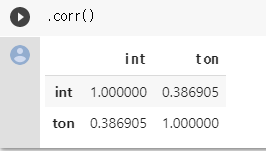

아래 결과는 사전 구축 code1로 Naver, Bond, Bok 데이터를 ngram화한 결과.  
사전 구축 code 로직은 크게 차이가 없는데도 결과값이 다름.  
문장 클렌징이 유의미한 영향을 끼친 게 아닐까 싶음.  

위의 결과는 문장 클렌징을 거쳐서 Hawkish/Dovish 비율이 1대1 정도인데 비해  
아래 결과는 문장 클렌징을 거치지 않아 Hawkish/Dovish 비율이 1대 1.5 정도.  

금리의 전반적인 추세가 down이었다면 Dovish 비율이 높은 사전으로 Correlation을 구한 게 더 높은 값을 보일 수 있음.